# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total PnL')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.9350,2102.4212,1.0000,-131.8862,-82.5138,-214.4001
JASMYUSDT,387.4585,225.2830,0.1072,0.0000,-162.1755,-162.1755
ETHUSDT,250.7473,174.4648,0.0830,0.0000,-76.2825,-76.2825
BBUSDT,60.1761,30.9074,0.0147,-39.7331,-29.2686,-69.0017
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
BNBUSDT,1.1421,0.9779,0.0005,-10.6060,-0.1642,-10.7703
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,81.3025,0.0387,-10.7239,4.4336,-6.2903
XRPUSDT,0.0000,0.0000,0.0000,-6.1145,0.0000,-6.1145
MKRUSDT,0.0000,0.0000,0.0000,-6.0975,0.0000,-6.0975


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities=quantities.sort_index()
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_quantity=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_quantity.index=pd.to_datetime(price_quantity.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_quantity[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total'][4:]

2024-09-27   -131.886217
2024-09-28   -131.886217
2024-09-29   -131.886217
2024-09-30   -131.886217
2024-10-01   -131.886217
2024-10-02   -131.886217
2024-10-03   -418.872086
2024-10-04   -341.823654
2024-10-05   -356.743174
2024-10-06   -322.367398
2024-10-07   -337.500769
2024-10-08   -344.180408
2024-10-09   -375.615395
2024-10-10   -347.926055
2024-10-11   -302.956679
2024-10-12   -276.666978
2024-10-13   -265.907701
2024-10-14   -142.332259
2024-10-15   -163.448396
2024-10-16   -168.424332
2024-10-17   -183.334771
2024-10-18   -176.385224
2024-10-19   -180.957063
2024-10-20   -143.937680
2024-10-21   -186.314601
2024-10-22   -201.935715
2024-10-23   -250.904729
2024-10-24   -234.108305
2024-10-25   -339.306249
2024-10-26   -322.303981
2024-10-27   -200.301397
2024-10-28   -222.114486
2024-10-29   -159.909168
2024-10-30   -155.100477
2024-10-31   -224.945662
Name: Total, dtype: float64

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

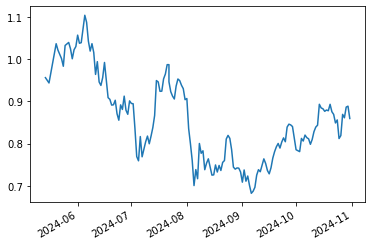

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APEUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT',
       'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT',
       'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PENDLEUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XECUSDT', 'XLMUSDT', 'XRPUSDT'],
      dtype='object')

In [34]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9352
TRXUSDT,0.0235
OMUSDT,0.0209
BNBUSDT,0.0141
PEPEUSDT,0.0031
RAYUSDT,0.0021
PENDLEUSDT,0.0007
SUIUSDT,0.0004
FDUSDUSDT,0.0000
JASMYUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.406785
BTCUSDT,0.300000
TRXUSDT,0.129003
BNBUSDT,0.093401
RAYUSDT,0.034614
PEPEUSDT,0.031357
SUIUSDT,0.004840


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.769965
OMUSDT,0.230035


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,674.625834,0.320880,0.230035,0.090845
BTCUSDT,615.998888,0.292995,0.000000,0.000000
SOLUSDT,298.860762,0.142151,0.000000,0.000000
JASMYUSDT,225.283001,0.107154,0.000000,0.000000
ETHUSDT,174.464817,0.082983,0.000000,0.000000
TRXUSDT,81.302548,0.038671,0.769965,-0.731294
BBUSDT,30.907438,0.014701,0.000000,0.000000
BNBUSDT,0.977899,0.000465,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,674.625834,0.320880,0.406785,-0.085905
BTCUSDT,615.998888,0.292995,0.300000,-0.007005
SOLUSDT,298.860762,0.142151,0.000000,0.000000
JASMYUSDT,225.283001,0.107154,0.000000,0.000000
ETHUSDT,174.464817,0.082983,0.000000,0.000000
TRXUSDT,81.302548,0.038671,0.129003,-0.090332
BBUSDT,30.907438,0.014701,0.000000,0.000000
BNBUSDT,0.977899,0.000465,0.093401,-0.092936
PEPEUSDT,0.000002,0.000000,0.031357,-0.031357
RAYUSDT,0.000000,0.000000,0.034614,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

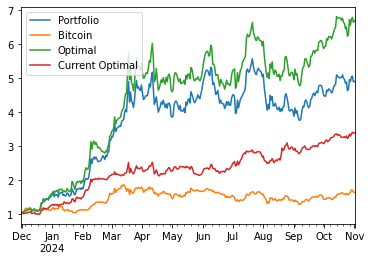

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

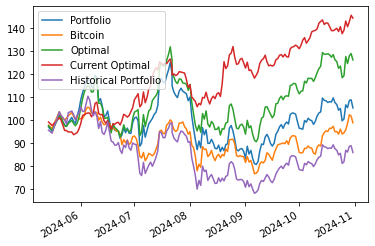

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-10-22,106.764954,95.025708,125.367267,139.831989,86.910207
2024-10-23,104.302052,93.952309,122.490074,138.453454,84.897981
2024-10-24,105.071509,96.083572,123.416589,140.539541,85.606483
2024-10-25,99.695111,93.946728,118.402473,137.471391,81.206074
2024-10-26,100.484202,94.500659,119.213888,138.993616,81.908466
2024-10-27,106.619006,95.800103,127.578052,142.977595,86.923713
2024-10-28,105.423532,98.494813,124.531333,140.510110,86.118716
2024-10-29,108.495385,102.324979,127.863010,142.665568,88.647197
2024-10-30,108.826328,101.772478,128.857628,145.476420,88.861818
2024-10-31,105.297003,98.842997,126.111525,144.243500,85.953443


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.611094
dtype: float64

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.510645
dtype: float64

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.594878
Bitcoin            0.430196
Optimal            0.611975
Current Optimal    0.380806
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.24184559916005424

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.109539,0.093401,0.018472,0.033660,0.005248,0.028412
BTCUSDT,0.189127,0.300000,0.044521,0.132940,0.044474,0.088466
OMUSDT,9.456614,0.406785,0.897782,0.749996,0.643294,0.106702
PEPEUSDT,0.063133,0.031357,0.008601,0.028352,0.004108,0.024244
RAYUSDT,0.095369,0.034614,0.011831,0.032715,0.004323,0.028392
SUIUSDT,0.004164,0.004840,0.000820,0.002378,0.000057,0.002321
TRXUSDT,0.068458,0.129003,0.017973,0.019958,0.003718,0.016240


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.148291,0.230035,0.274671,0.428313,0.374541,0.053772
TRXUSDT,0.229087,0.769965,0.725329,0.571687,0.517915,0.053772


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.208370,0.323232,0.451604,0.428388,0.262659,0.165728
BTCUSDT,0.014250,0.292929,0.260954,0.188940,0.051604,0.137335
SOLUSDT,-0.001983,0.141414,0.118449,0.142094,0.031072,0.111022
JASMYUSDT,-0.030844,0.111111,0.068188,0.154699,0.039941,0.114758
ETHUSDT,-0.017909,0.080808,0.053433,0.063500,0.006780,0.056720
TRXUSDT,0.012021,0.040404,0.044536,0.005866,0.000507,0.005359
BBUSDT,-0.006763,0.010101,0.002835,0.016515,0.000681,0.015834


# Value At Risk

## Historical

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.050112467076171584, -0.07484858685793225)

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.0481968870558993, -0.06570618900383866)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT       0.012922
BTCUSDT     -0.021642
SOLUSDT     -0.009022
JASMYUSDT   -0.018395
ETHUSDT     -0.008529
TRXUSDT     -0.001597
BBUSDT      -0.001298
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047562
Name: 2024-08-05 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.024063
BTCUSDT     -0.012703
SOLUSDT     -0.010203
JASMYUSDT   -0.010495
ETHUSDT     -0.004801
TRXUSDT     -0.000657
BBUSDT      -0.000970
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.063892
dtype: float64

## Parametric

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06341045082997453, -0.08127466594535329)

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.052910961934558035, -0.06781722412933419)

## Multivariate

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.058054554602451694, -0.07390146977487758)

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05067457631892154, -0.06410578490940996)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.021506
BTCUSDT     -0.009629
SOLUSDT     -0.007126
JASMYUSDT   -0.008871
ETHUSDT     -0.003137
TRXUSDT     -0.000318
BBUSDT      -0.000800
Portfolio   -0.051386
dtype: float64

## Copulas

### Gaussian Copula

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055707676443741784, -0.07262023895894744)

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.04997379884314886, -0.0636893446203401)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021336
BTCUSDT     -0.009849
SOLUSDT     -0.007733
JASMYUSDT   -0.007603
ETHUSDT     -0.003538
TRXUSDT     -0.000313
BBUSDT      -0.000892
Portfolio   -0.051265
dtype: float64

### Student Copula

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0563075828263399, -0.07304920520189598)

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.053793544945078674, -0.06879483782015651)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021009
BTCUSDT     -0.010060
SOLUSDT     -0.007705
JASMYUSDT   -0.008750
ETHUSDT     -0.003704
TRXUSDT     -0.000265
BBUSDT      -0.000946
Portfolio   -0.052441
dtype: float64

### Gumbel Copula

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11321493679571615, -0.15881622860187455)

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07047617103105837, -0.09693721093663533)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.048871
BTCUSDT     -0.008553
SOLUSDT     -0.004327
JASMYUSDT   -0.006678
ETHUSDT     -0.001074
TRXUSDT      0.000216
BBUSDT      -0.000078
Portfolio   -0.069365
dtype: float64

### Monte Carlo

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06447010058650278, -0.08098062982950921)

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05363382483765551, -0.06777852156913783)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.022972
BTCUSDT     -0.009883
SOLUSDT     -0.007812
JASMYUSDT   -0.008368
ETHUSDT     -0.003384
TRXUSDT     -0.000345
BBUSDT      -0.000943
Portfolio   -0.053707
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054952,-0.098826,-0.082872,-0.021995
2024-01-15,-0.054952,-0.098831,-0.082172,0.012536
2024-01-16,-0.054952,-0.098908,-0.083044,0.049523
2024-01-17,-0.054952,-0.100515,-0.084426,-0.025584
2024-01-18,-0.054952,-0.102266,-0.085373,-0.029147
...,...,...,...,...
2024-10-29,-0.035771,-0.052015,-0.047746,0.026754
2024-10-30,-0.035771,-0.050744,-0.046258,0.007779
2024-10-31,-0.035771,-0.051244,-0.047812,-0.021311
2024-11-01,-0.035771,-0.051191,-0.046413,0.006056


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.030005,-0.083133,-0.076262,-0.016624
2024-05-29,-0.028792,-0.080533,-0.075582,-0.008973
2024-05-30,-0.028792,-0.069074,-0.065047,0.031615
2024-05-31,-0.028792,-0.068750,-0.061277,0.027617
2024-06-01,-0.028792,-0.069954,-0.061906,0.041212
...,...,...,...,...
2024-10-29,-0.047235,-0.058380,-0.057902,0.029138
2024-10-30,-0.047235,-0.058126,-0.057176,0.003050
2024-10-31,-0.048546,-0.061403,-0.063786,-0.032431
2024-11-01,-0.048546,-0.061314,-0.061874,0.000439


<AxesSubplot:>

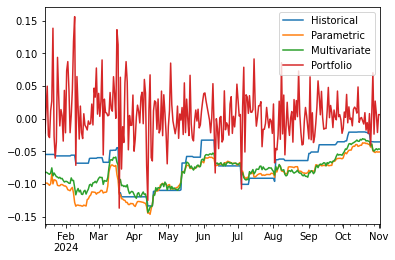

In [79]:
var_data.plot()

<AxesSubplot:>

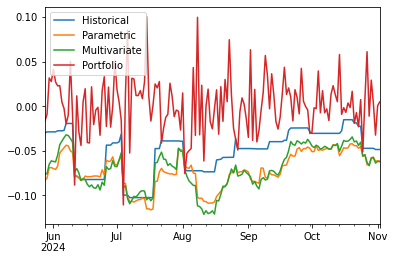

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02381,0.010204,0.010204
Kupiec Stat,5.223234,14.348003,14.348003
P-value,0.022287,0.000152,0.000152


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069182,0.018868,0.018868
Kupiec Stat,1.105918,4.213113,4.213113
P-value,0.292971,0.040113,0.040113


## Principal Component Analysis

### Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79026464, 0.06746934, 0.05512819, 0.04548813, 0.04164969])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014468
ADAUSDT     0.014592
ALGOUSDT    0.016133
APEUSDT     0.018108
APTUSDT     0.015596
              ...   
WBTCUSDT    0.010102
WLDUSDT     0.022314
XECUSDT     0.015548
XLMUSDT     0.009629
XRPUSDT     0.009343
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

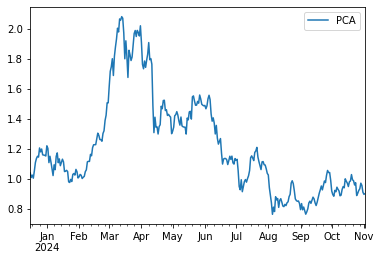

In [85]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

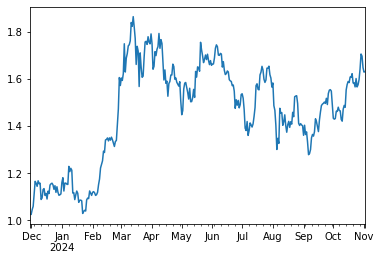

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.353263
ALGOUSDT     0.355832
ETHUSDT      0.363125
WBETHUSDT    0.363288
               ...   
RAYUSDT      0.980613
PEPEUSDT     1.012722
FLOKIUSDT    1.019766
WLDUSDT      1.073390
OMUSDT       1.335240
Length: 64, dtype: float64

<AxesSubplot:>

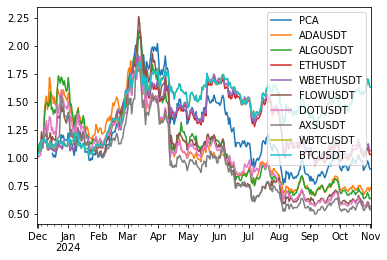

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

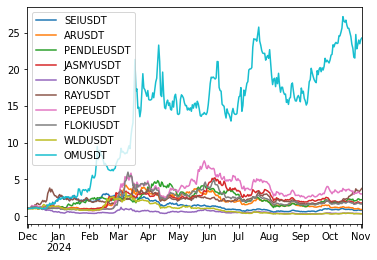

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67706092, 0.13281557, 0.09166163, 0.06662892, 0.03183297])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095980
BTCUSDT      0.065205
SOLUSDT      0.105330
JASMYUSDT    0.156070
ETHUSDT      0.087711
TRXUSDT      0.014120
BBUSDT       0.237845
BNBUSDT      0.067589
PEPEUSDT     0.170151
Name: PC1, dtype: float64

<AxesSubplot:>

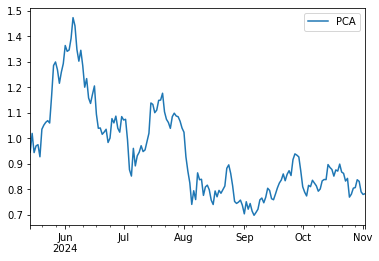

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

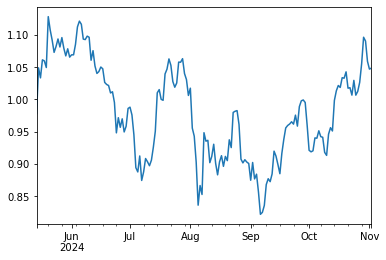

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.342901
SOLUSDT      0.355578
BTCUSDT      0.382207
BNBUSDT      0.386471
JASMYUSDT    0.431557
PEPEUSDT     0.486748
TRXUSDT      0.579412
OMUSDT       0.587241
BBUSDT       0.642956
dtype: float64

<AxesSubplot:>

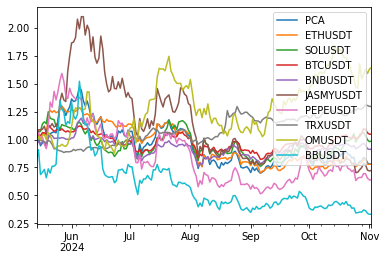

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.947866
BBUSDT       1.619691
JASMYUSDT    1.307798
SOLUSDT      1.165429
BTCUSDT      1.000000
ETHUSDT      0.961785
OMUSDT       0.952564
BNBUSDT      0.677877
TRXUSDT      0.269855
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.028414
PEPEUSDT     1.780198
JASMYUSDT    1.714549
ETHUSDT      1.131803
BTCUSDT      1.000000
SOLUSDT      0.989835
BNBUSDT      0.742695
OMUSDT       0.505959
TRXUSDT      0.225536
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451


In [99]:
results={}
window=14
days=90
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APEUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XECUSDT,XLMUSDT,XRPUSDT
2024-08-18,0.116098,0.011796,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.741023,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.064755,0.000000
2024-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.564892,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000
2024-09-15,0.000000,0.000000,0.000000,0.002626,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000384,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000
2024-09-29,0.134704,0.013686,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.1206,0.0,0.000000,0.550266
2024-10-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.424956,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000
2024-10-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000
2024-11-02,0.000000,0.000000,0.000003,0.000005,0.000013,0.000001,0.000005,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000


In [100]:
rolling_optimization.iloc[-3].sort_values(ascending=False)

OMUSDT      0.542418
TRXUSDT     0.424956
SUIUSDT     0.032626
AAVEUSDT    0.000000
SEIUSDT     0.000000
              ...   
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
IMXUSDT     0.000000
XRPUSDT     0.000000
Name: 2024-10-13 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

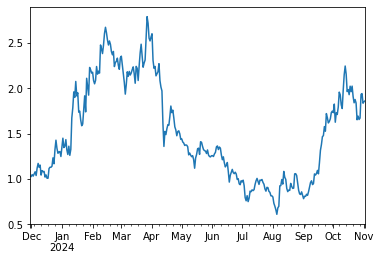

In [101]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()